# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
sns.set()
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [3]:
import os
import pandas as pd
import numpy as np

def load_data(data_dir='data/raw'):
    records = []

    for subject_id in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue

        for session in ['Final', 'Midterm 1', 'Midterm 2']:
            session_path = os.path.join(subject_path, session)
            if not os.path.isdir(session_path):
                continue

            try:
                def read_signal(file_path, col_name):
                    with open(file_path, 'r') as f:
                        lines = f.readlines()
                        start_time = float(lines[0].strip())
                        interval = float(lines[1].strip())
                        values = [float(line.strip()) for line in lines[2:]]
                        timestamps = [start_time + i * interval for i in range(len(values))]
                        return pd.DataFrame({'timestamp': timestamps, col_name: values})

                hr_df = read_signal(os.path.join(session_path, 'HR.csv'), 'heart_rate')
                eda_df = read_signal(os.path.join(session_path, 'EDA.csv'), 'eda')
                temp_df = read_signal(os.path.join(session_path, 'TEMP.csv'), 'temperature')

                # Merge signals on timestamp using outer joins to include all timestamps
                df = pd.merge(hr_df, eda_df, on='timestamp', how='outer')
                df = pd.merge(df, temp_df, on='timestamp', how='outer')

                # Sort by timestamp
                df = df.sort_values('timestamp').reset_index(drop=True)

                # Add metadata
                df['subject_id'] = subject_id
                df['session'] = session

                records.append(df)

            except Exception as e:
                print(f"Error processing {subject_id}/{session}: {e}")
                continue

    if records:
        return pd.concat(records, ignore_index=True)
    else:
        return pd.DataFrame(columns=['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session'])

data = load_data('data/')
print(data.head())
print(data.dtypes)

      timestamp  heart_rate       eda  temperature subject_id session
0  1.544027e+09         NaN  0.000000        21.71         S5   Final
1  1.544027e+09         NaN  0.002562        21.71         S5   Final
2  1.544027e+09         NaN  0.020495        21.71         S5   Final
3  1.544027e+09       118.0       NaN          NaN         S5   Final
4  1.544027e+09        84.5       NaN          NaN         S5   Final
timestamp      float64
heart_rate     float64
eda            float64
temperature    float64
subject_id      object
session         object
dtype: object


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [16]:
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore

def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Drop rows with missing subject_id or session
    data = data.dropna(subset=['subject_id', 'session'])

    # Fill missing numerical values with median
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

    # Convert timestamp to datetime and resample
    if not np.issubdtype(data['timestamp'].dtype, np.datetime64):
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    
    data = data.sort_values('timestamp')

    # Remove outliers using Z-score (threshold = 3.5)
    z_scores = np.abs(zscore(data[numerical_cols], nan_policy='omit'))
    z_scores = np.abs(zscore(data[numerical_cols], nan_policy='omit'))
    data = data[(z_scores < 3.5).all(axis=1)]

    # Save per subject
    for subject in data['subject_id'].dropna().unique():
        subject_data = data[data['subject_id'] == subject]
        subject_str = str(subject)
        file_path = os.path.join(output_dir, f"{subject_str}_processed.csv")
        subject_data.to_csv(file_path, index=False)

    return data

processed = preprocess_data(data)
print(processed.head())

                  timestamp  heart_rate       eda  temperature subject_id  \
72426   2018-10-13 12:55:21      102.02  0.000000        22.23         S5   
1344360 2018-10-13 12:55:25      102.02  0.000000        22.11        S10   
72427   2018-10-13 12:55:25      102.02  0.002562        22.23         S5   
1344361 2018-10-13 12:55:29      102.02  0.001281        22.11        S10   
72428   2018-10-13 12:55:29      102.02  0.021779        22.23         S5   

           session  
72426    Midterm 1  
1344360  Midterm 1  
72427    Midterm 1  
1344361  Midterm 1  
72428    Midterm 1  


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

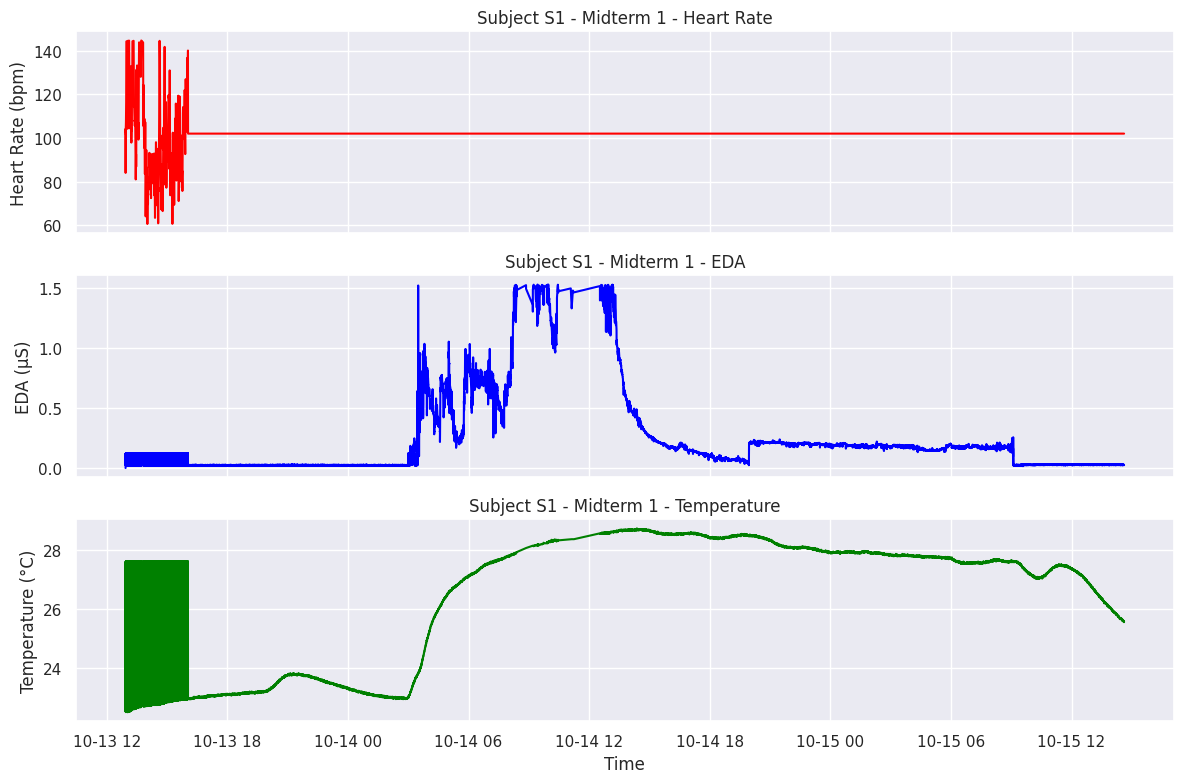

In [19]:
import os
import matplotlib.pyplot as plt

def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter data for specific subject and session
    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)]

    if subset.empty:
        print(f"No data found for subject {subject_id} in session '{session}'.")
        return None

    # Create figure and subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    
    # Heart Rate
    axs[0].plot(subset['timestamp'], subset['heart_rate'], color='red')
    axs[0].set_ylabel('Heart Rate (bpm)')
    axs[0].set_title(f'Subject {subject_id} - {session} - Heart Rate')

    # EDA
    axs[1].plot(subset['timestamp'], subset['eda'], color='blue')
    axs[1].set_ylabel('EDA (μS)')
    axs[1].set_title(f'Subject {subject_id} - {session} - EDA')

    # Temperature
    axs[2].plot(subset['timestamp'], subset['temperature'], color='green')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].set_title(f'Subject {subject_id} - {session} - Temperature')
    axs[2].set_xlabel('Time')

    # Tidy layout and save
    plt.tight_layout()
    filename = f"S{subject_id}_{session.replace(' ', '_')}_signals.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)

    return fig

# Example trial for subject 1 (S1), Midterm 1
fig = plot_physiological_signals(data, subject_id='S1', session='Midterm 1')
plt.show()